In [89]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import log_loss, f1_score
from pathlib import Path
import pycaret.classification as pc
import pycaret.regression as pr

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.models.signature import ModelSignature
from mlflow.tracking import MlflowClient

import matplotlib.pyplot as plt


import streamlit
import os
import leitura_dados

## Leitura de dados

In [2]:
df_prod = leitura_dados.leitura_arquivo('../data/raw/dataset_kobe_prod.parquet')

### Configuração MLFlow

In [3]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri('sqlite:///../data/mlruns.db')

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id  = experiment.experiment_id

2025/04/13 21:11:28 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/04/13 21:11:28 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [4]:
columns = ['lat', 'lon' , 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag'] # Não foi encontrado a coluna "lng". Substituido pela coluna "lon"


# TODO: 2.2 Colocar o pdf do diagrama.png dentro do /docs # opcional Colocar no README
# TODO: 3 Colocar a resposta no README.md


#TODO: Colocar todo o codigo do notebook em funções no arquivo .py
#C:\Users\vinni\OneDrive\Área de Trabalho\Geral\códigos\Aulas\Pós INFNET\2_Engenharia_Machine_Learning\projeto\kobe_predict\code
# pipeline run 'PreparacaoDados"
with mlflow.start_run(experiment_id=experiment_id, run_name='PreparacaoDados'):

    df_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

    df_dev.dropna(subset=['shot_made_flag'], inplace=True) # Somente a coluna "shot_made_flag" tinha dados faltantes
    df_dev = df_dev[columns] # shape 20285, 5
    df_dev.to_parquet('../data/processed/data_filtered.parquet')

    df_dev_columns = df_dev[['lat', 'lon' , 'minutes_remaining', 'period', 'playoffs', 'shot_distance']]
    df_dev_target = df_dev['shot_made_flag']
    train_perc = 0.8

    xtrain, xtest, ytrain, ytest = train_test_split(df_dev_columns,
                                                    df_dev_target,
                                                    train_size=train_perc,
                                                    stratify=df_dev_target)

    xtrain['shot_made_flag'] = ytrain
    xtest['shot_made_flag'] = ytest

    xtrain.to_parquet('../data/processed/base_train.parquet')
        xtest.to_parquet('../data/processed/base_test.parquet')

    mlflow.log_params({'perc_test':1 - train_perc, 'select_columns': columns})
    mlflow.log_metrics({'qtde_linhas_train': xtrain.shape[0], 'qtde_linhas_test': xtest.shape[0]})
    

In [45]:
 def plot_parameter_validation_curve(x, y, param_name, grid_search,
                                     model, model_name, scoring,
                                     logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = x,
                                                 y = y,
                                                 param_name=param_name,
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                 color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    
    # Salvar imagem automaticamente
    filename = f"validation_curve_{model_name.replace(' ', '_').lower()}.png"
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight')
    print(f"Gráfico salvo como: {filename}")
    plt.show()
    plt.close()
    

In [48]:
mlflow.end_run()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:51:59
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/14 [00:00<?, ?it/s]

Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1
Gráfico salvo como: validation_curve_regressão_logística.png


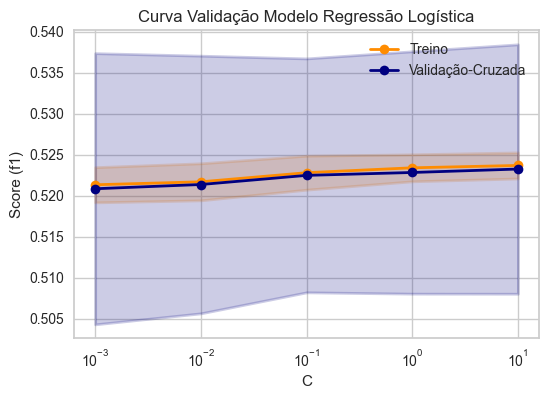

Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1
Gráfico salvo como: validation_curve_árvore_de_descisão.png


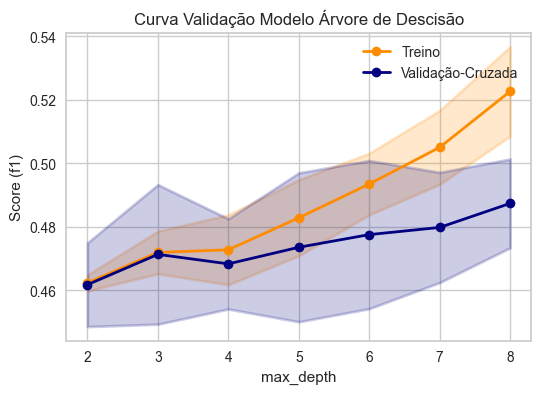

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:52:27
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'Kobe Predict' already exists. Creating a new version of this model...
Created version '10' of model 'Kobe Predict'.


<Figure size 800x550 with 0 Axes>

In [87]:
registered_model_name = 'Kobe Predict' 
n_example = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name='Treinamento'):

    exp = pc.setup(
        data=xtrain,
        target='shot_made_flag',
        test_data=xtest,
        normalize=True,
        log_experiment=False
    )
    list_models = exp.compare_models(['lr', 'dt'], n_select=2, sort='f1')

    # Regressão Logística
    exp.plot_model(list_models[1], plot='vc',save=True) # 
    yhat_test = exp.predict_model(list_models[1])

    plot_parameter_validation_curve(xtrain.drop('shot_made_flag', axis=1), ytrain, 'C', {'C':[0.001, 0.01, 0.1, 1, 10]}, list_models[1], 'Regressão Logística', 'f1', logx=True)

    mlflow.log_metrics({
        'lr_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
        'lr_f1': f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label'])
    })

    plt.savefig('rl_validation_curve.png')
    mlflow.log_artifact('rl_validation_curve.png')
    #os.remove('rl_validation_curve.png')


    ## Arvore de Descisão 
    exp.plot_model(list_models[0], plot='vc',save=True) # 
    yhat_test = exp.predict_model(list_models[0])

    plot_parameter_validation_curve(xtrain.drop('shot_made_flag', axis=1),
                                    ytrain,
                                    'max_depth',
                                    {'max_depth':[2, 3, 4, 5, 6, 7, 8]},
                                    list_models[0],
                                    'Árvore de Descisão',
                                    'f1',
                                    logx=False)

    mlflow.log_metrics({
        'lr_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
        'lr_f1': f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label'])
    })

    plt.savefig('dt_validation_curve.png')
    mlflow.log_artifact('dt_validation_curve.png')
    #os.remove('dt_validation_curve.png')

    # Finalização do Modelo
    tune_model = exp.tune_model(list_models[0],
                                optimize='f1',
                                search_library='scikit-learn',
                                search_algorithm='random',
                                n_iter=4)

    yhat_test = exp.predict_model(tune_model, raw_score=True)
    mlflow.log_metrics({
        'final_model_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
        'final_model_f1': f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label'])
    })
    yhat_test.to_parquet('../data/processed/prediction_test.parquet')
    mlflow.log_artifact('../data/processed/prediction_test.parquet')
    
    final_model = exp.finalize_model(tune_model)

    # Exportação para Log e registro do modelo  
    exp.save_model(final_model, f'./{registered_model_name}')
    # Carrega novamente o pipeline + bestmodel
    model_pipe = exp.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(xtrain.drop('shot_made_flag', axis=1).columns)
    inf_signature = infer_signature(xtrain[model_features], 
                                    model_pipe.predict(xtrain.drop('shot_made_flag', axis=1)))
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:n_example] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name=registered_model_name,
        alias='staging',
        version=model_version
    ) 

In [ ]:
import pandas as pd
import mlflow
from mlflow.sklearn import load_model
from pycaret.classification import predict_model
from sklearn.metrics import log_loss, f1_score

# Configuração do MLflow com SQLite
mlflow.set_tracking_uri('sqlite:///../data/mlruns.db')

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id

columns = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']

with mlflow.start_run(experiment_id=experiment_id, run_name='PipelineAplicacao'):

    # Carrega o modelo da versão em staging
    model_uri = "models:/Kobe Predict@staging"
    loaded_model = load_model(model_uri)

    # Carrega os dados de produção
    data_prod = pd.read_parquet('../data/raw/dataset_kobe_prod.parquet')

    # Faz predição usando PyCaret
    yhat = predict_model(loaded_model, data=data_prod)

    # Salva o resultado como artefato .parquet
    yhat.to_parquet('../data/processed/prediction_prod.parquet')
    mlflow.log_artifact('../data/processed/prediction_prod.parquet')

    # Calcula e loga métricas se a coluna alvo estiver presente
    if 'shot_made_flag' in yhat.columns:
        y_true = yhat['shot_made_flag']
        y_pred_label = yhat['prediction_label']
        y_pred_score = yhat['prediction_score']

        mlflow.log_metrics({
            'log_loss_prod': log_loss(y_true, y_pred_score),
            'f1_score_prod': f1_score(y_true, y_pred_label)
        })
        print("✅ Métricas logadas com sucesso.")
    else:
        print("⚠️ Coluna 'shot_made_flag' não encontrada nos dados. Métricas não foram logadas.")
